# Life Expectancy Kaggle Problem
Solves the problem using the custom linear unit
implementation and a library for comparison and validation (multiple inputs, single output).

Kaggle link: https://www.kaggle.com/datasets/kumarajarshi/life-expectancy-who

In [1]:
import copy
import os
import warnings

import dotenv
_ = dotenv.load_dotenv()
warnings.filterwarnings('ignore')

import kagglehub
import keras
import pandas as pd
import statsmodels.api as sm
from matplotlib import gridspec as gridspec
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection._split import train_test_split
from sklearn.preprocessing import StandardScaler

from app.loggers import get_logger
from app.models import LinearUnit

logger = get_logger(__name__)

In [2]:
def get_data_report(x, y):
    x = copy.deepcopy(x)
    x = sm.add_constant(x)
    model = sm.OLS(y, x).fit()
    logger.info(model.summary())
    residuals = model.resid

    # 2. Create a Residual Plot (Residuals vs. Fitted Values)
    plt.scatter(model.fittedvalues, residuals)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')
    plt.show()

## Data

In [3]:
data_dir_fp = kagglehub.dataset_download("kumarajarshi/life-expectancy-who")
data_fp = os.path.join(data_dir_fp, "Life Expectancy Data.csv")
df = pd.read_csv(data_fp)
df.columns = df.columns.str.strip()
df.dtypes

Country                             object
Year                                 int64
Status                              object
Life expectancy                    float64
Adult Mortality                    float64
infant deaths                        int64
Alcohol                            float64
percentage expenditure             float64
Hepatitis B                        float64
Measles                              int64
BMI                                float64
under-five deaths                    int64
Polio                              float64
Total expenditure                  float64
Diphtheria                         float64
HIV/AIDS                           float64
GDP                                float64
Population                         float64
thinness  1-19 years               float64
thinness 5-9 years                 float64
Income composition of resources    float64
Schooling                          float64
dtype: object

## Analysis

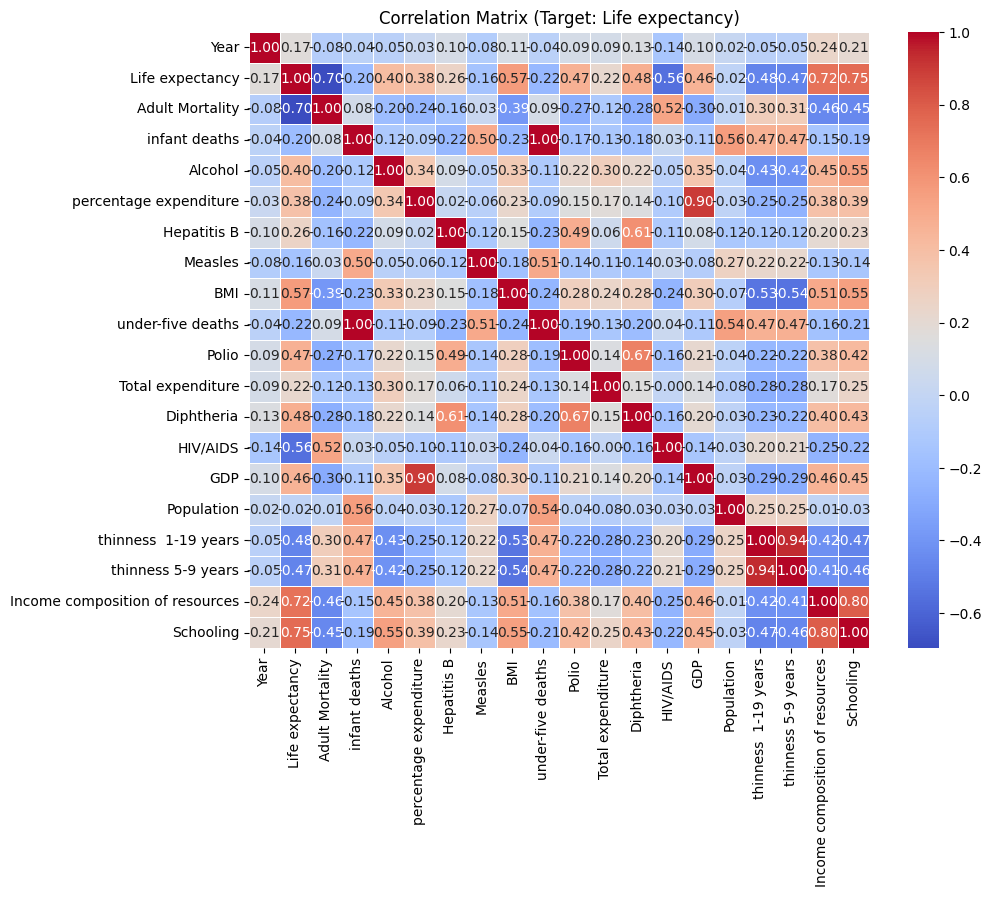

2025-12-22 18:17:19,016 - deep_learning.__main__ - INFO - --- Top Linear Predictors --- (2879330.py:17)
2025-12-22 18:17:19,018 - deep_learning.__main__ - INFO -                                  Life expectancy
Life expectancy                         1.000000
Schooling                               0.751975
Income composition of resources         0.724776
BMI                                     0.567694
Diphtheria                              0.479495
Polio                                   0.465556
GDP                                     0.461455
Alcohol                                 0.404877
percentage expenditure                  0.381864
Hepatitis B                             0.256762
Total expenditure                       0.218086
Year                                    0.170033
Population                             -0.021538
Measles                                -0.157586
infant deaths                          -0.196557
under-five deaths                      -0.222529
thinn

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_correlation_matrix(df, target_col):
    # Calculate correlations
    corr = df.corr()
    
    # Sort correlations with respect to the target to see which features matter most
    target_corr = corr[[target_col]].sort_values(by=target_col, ascending=False)
    
    # Plotting
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title(f'Correlation Matrix (Target: {target_col})')
    plt.show()
    
    logger.info("--- Top Linear Predictors ---")
    logger.info(target_corr)
df_numeric = df.drop(columns=['Country', 'Status'])
plot_correlation_matrix(df_numeric, 'Life expectancy')

2025-12-22 18:17:19,034 - deep_learning.__main__ - INFO -                             OLS Regression Results                            
Dep. Variable:        Life expectancy   R-squared:                       0.697
Model:                            OLS   Adj. R-squared:                  0.697
Method:                 Least Squares   F-statistic:                     3364.
Date:                Mon, 22 Dec 2025   Prob (F-statistic):               0.00
Time:                        18:17:19   Log-Likelihood:                -9005.4
No. Observations:                2928   AIC:                         1.802e+04
Df Residuals:                    2925   BIC:                         1.803e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

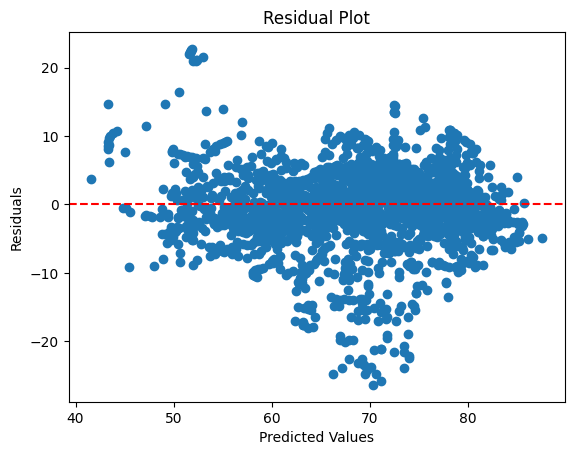

In [5]:
df_numeric = df.select_dtypes(include=['number'])
df_numeric = df_numeric.dropna(subset=['Life expectancy'])
df_numeric = df_numeric.fillna(df_numeric.mean())

df_clean = df_numeric.dropna(subset=['Schooling', 'Adult Mortality', 'Life expectancy'])

X = df_clean[['Schooling', 'Adult Mortality']]
y = df_clean['Life expectancy']

get_data_report(X, y)

## Data Preparation

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Parameters

In [7]:
learning_rate = 0.001
batch_size = 32
epochs = 40

## Training

In [8]:
# Scikit Linear Regression
sk_model = LinearRegression()
logger.info("Training Linear Regression")
sk_model.fit(X_train_scaled, y_train)
sk_model_preds = sk_model.predict(X_test_scaled)
sk_score = sk_model.score(X_test_scaled, y_test)

# Keras
model_keras = keras.Sequential(
    [
        keras.layers.Dense(
            1,
            input_shape=(X_train_scaled.shape[1:]),
            activation="linear",
            kernel_initializer="glorot_uniform",
            bias_initializer="glorot_uniform",
        )
    ]
)
model_keras.compile(
    optimizer=keras.optimizers.SGD(learning_rate=learning_rate), loss="mse"
)
logger.info("Training Keras Model")
model_keras.fit(X_train_scaled, y_train, epochs=epochs, batch_size=batch_size)
keras_preds = model_keras.predict(X_test_scaled)
keras_score = r2_score(y_test, keras_preds)

linear_unit = LinearUnit(X_train_scaled.tolist(), [[yi] for yi in y_train])
logger.info("Training Linear Unit")
linear_unit.train(learning_rate=learning_rate, epochs=epochs, batch_size=batch_size)
lu_preds = linear_unit.infer(X_test_scaled.tolist()).flatten()
lu_score = r2_score(y_test, lu_preds)

2025-12-22 18:17:19,123 - deep_learning.__main__ - INFO - Training Linear Regression (558161515.py:3)
E0000 00:00:1766445439.149237   32523 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1766445439.157449   32523 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2025-12-22 18:17:19,206 - deep_learning.__main__ - INFO - Training Keras Model (558161515.py:23)


Epoch 1/40
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step - loss: 4263.4438
Epoch 2/40
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - loss: 3174.9978
Epoch 3/40
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step - loss: 2366.3572
Epoch 4/40
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step - loss: 1766.7360
Epoch 5/40
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step - loss: 1319.3533
Epoch 6/40
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step - loss: 987.5763
Epoch 7/40
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step - loss: 741.1803
Epoch 8/40
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - loss: 558.0582
Epoch 9/40
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 422.0800
Epoch 10/40
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step - loss: 321.1116
Epoch 11/40
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step - loss: 245.9876
Epoch 12/40
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - loss: 190.1960
Epoch 13/40
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step - loss: 148.6793
Epoch 14/40
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step - loss: 117.8026
Epoch 15/40
74/74 ━━━━━━

2025-12-22 18:17:21,965 - deep_learning.__main__ - INFO - Training Linear Unit (558161515.py:29)


## Results

In [9]:
logger.info("Total rows: %s", len(X))
logger.info("LinearReg W: %s", sk_model.coef_)
logger.info("LinearReg b: %s", sk_model.intercept_)
logger.info("Linear Unit W: %s", linear_unit.w_current.matrix)
logger.info("Linear Unit b: %s", linear_unit.b_current.matrix)
logger.info("Linear Unit latest loss: %s", linear_unit.epoch_loss_scores[-1])
logger.info(
    "\nScores:\n====================\nLinearReg Score:%s\nKeras Score:%s\nLinear Unit Score:%s",
    sk_score,
    keras_score,
    lu_score,
)

2025-12-22 18:17:22,191 - deep_learning.__main__ - INFO - Total rows: 2928 (1395121864.py:1)
2025-12-22 18:17:22,191 - deep_learning.__main__ - INFO - LinearReg W: [ 4.84673763 -4.56251137] (1395121864.py:2)
2025-12-22 18:17:22,192 - deep_learning.__main__ - INFO - LinearReg b: 69.14901793339027 (1395121864.py:3)
2025-12-22 18:17:22,193 - deep_learning.__main__ - INFO - Linear Unit W: [[4.865904902072217], [-4.543066067393596]] (1395121864.py:4)
2025-12-22 18:17:22,194 - deep_learning.__main__ - INFO - Linear Unit b: [[68.95039079209583]] (1395121864.py:5)
2025-12-22 18:17:22,195 - deep_learning.__main__ - INFO - Linear Unit latest loss: 29.173557423448596 (1395121864.py:6)
2025-12-22 18:17:22,195 - deep_learning.__main__ - INFO - 
Scores:
LinearReg Score:0.7184360757541752
Keras Score:0.7173692726296688
Linear Unit Score:0.7173901884754572 (1395121864.py:7)


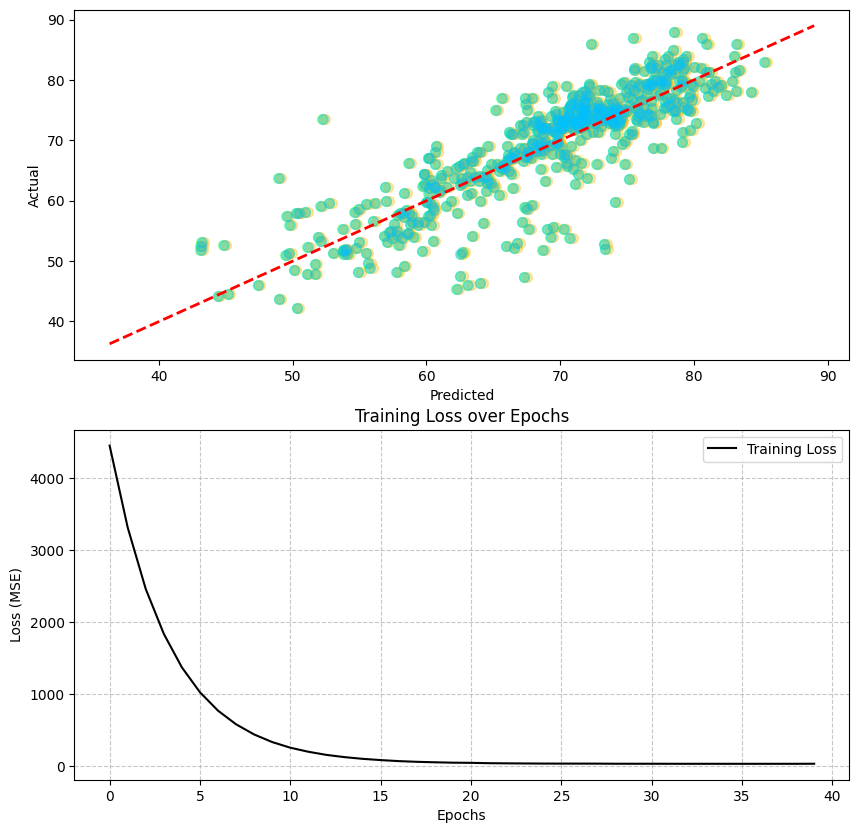

In [12]:
fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(2, 2)
data_pt = fig.add_subplot(gs[0, :])
data_pt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2) 
data_pt.set_xlabel('Predicted')
data_pt.set_ylabel('Actual')
data_pt.scatter(lu_preds, y_test, color="#11ff1155", s=50) #green
data_pt.scatter(sk_model_preds, y_test, color="#fcba0355", s=50) #orange
data_pt.scatter(keras_preds, y_test, color="#03c2fc55", s=50) # blue

loss_pt = fig.add_subplot(gs[1, :])
loss_pt.plot(linear_unit.epoch_loss_scores, label="Training Loss", color="black")
loss_pt.set_title("Training Loss over Epochs")
loss_pt.set_xlabel("Epochs")
loss_pt.set_ylabel("Loss (MSE)")
loss_pt.grid(True, linestyle="--", alpha=0.7)
loss_pt.legend()
plt.show()